In [1]:
import os
from sam import chdir_to_repopath
chdir_to_repopath()
from sam.dose_reponse_fit import dose_response_fit, ModelPredictions, survival_to_stress, FitSettings, Transforms
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sam.data_formats import read_data, load_files, load_datapoints
from sam.plotting import plot_fit_prediction
from sam.system_stress import pred_surv_without_hormesis
from sam.helpers import detect_hormesis_index, pad_c0, compute_lc_from_curve, weibull_2param, weibull_2param_inverse, compute_lc, ll5_inv
from sam.data_formats import ExperimentData
from scipy.optimize import brentq
import seaborn as sns
from sam.stress_addition_model import OLD_STANDARD, sam_prediction, get_sam_lcs, stress_to_survival, survival_to_stress

In [2]:
preds = []
for path, data, stress, ser in load_datapoints():
    exp_name = os.path.split(path)[1].replace(".xlsx", "")
    r_path = f"migration/r/{exp_name}_{stress}_williams_and_linear_interpolation_lmcurve.csv"
    title = f"{exp_name}_{stress}"
    r_pred = pd.read_csv(r_path)
    
    main_fit, stress_fit, sam_sur, sam_stress, additional_stress  = sam_prediction(data.main_series, ser, data.meta, OLD_STANDARD)
    preds.append((r_pred, stress_fit, title))

huang_Flupyradifurone_2023_Temp_15


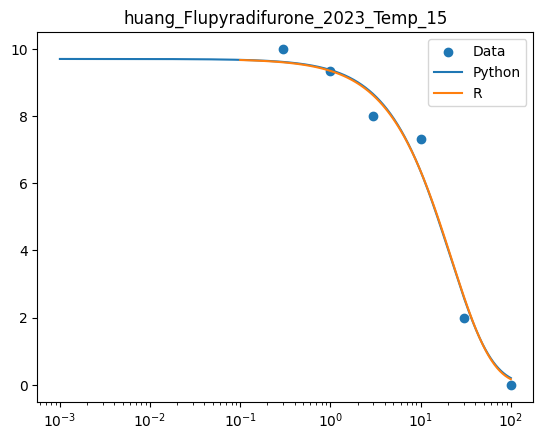

naeem_Esfenvalerate_2019_Prochloraz_1


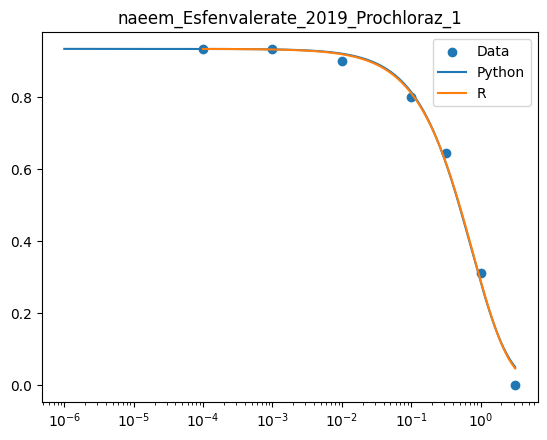

naeem_Esfenvalerate_2019_Prochloraz_32


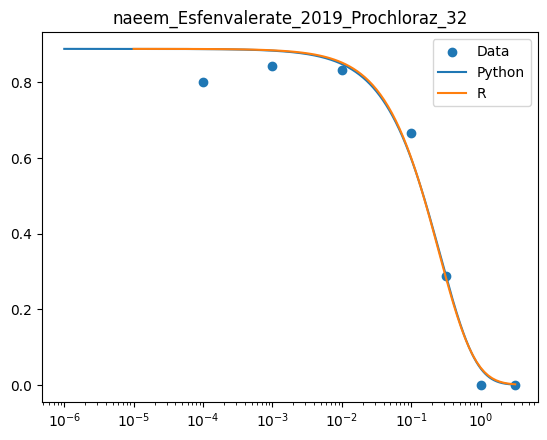

naeem_Esfenvalerate_2019_Prochloraz_100


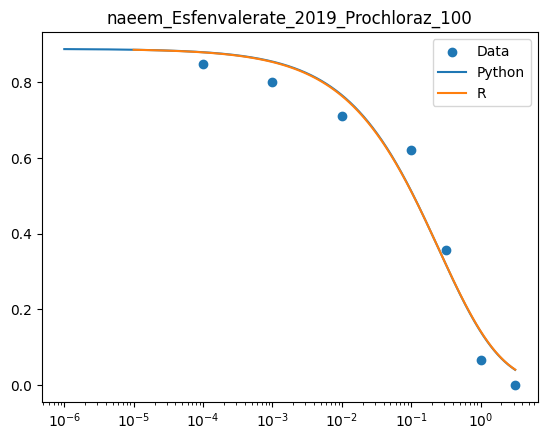

naeem_Esfenvalerate_2019_Food_1%


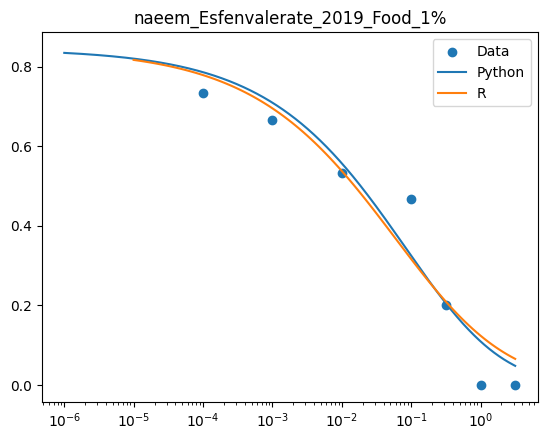

naeem_Esfenvalerate_2019_Food_1% + Prochloraz_1


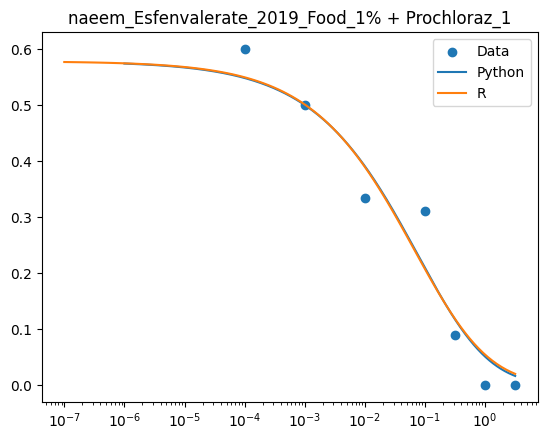

naeem_Esfenvalerate_2019_Food_1% + Prochloraz_32


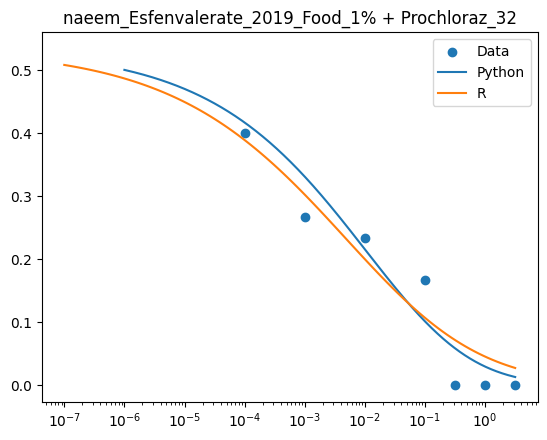

naeem_Esfenvalerate_2019_Food_1% + Prochloraz_100


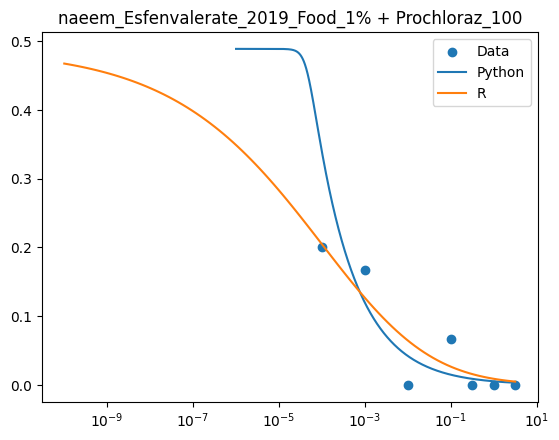

ayesha-cloth_Clothianidin_2024_agricultural_pre-contamination_Temp_20


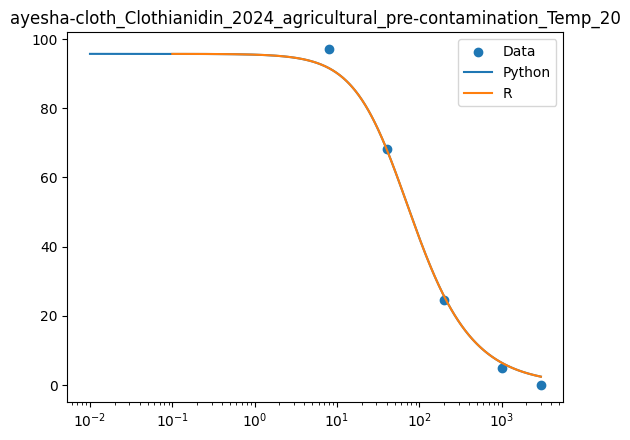

ayesha-cloth_Clothianidin_2024_agricultural_pre-contamination_Temp_24


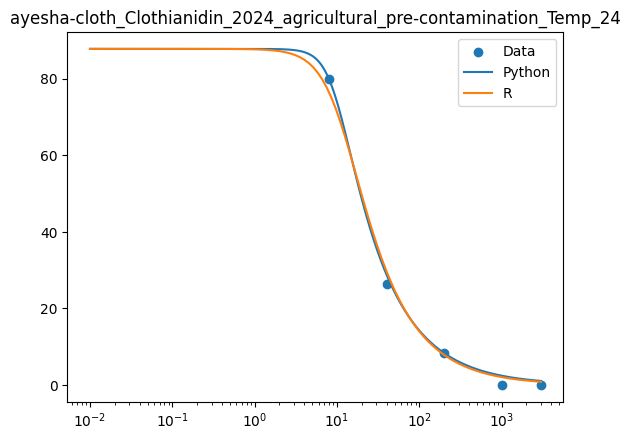

naeem_Esfenvalerate_2024_Food_1%


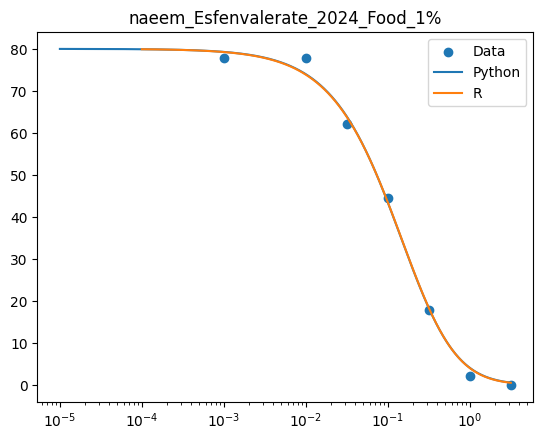

naeem_Esfenvalerate_2024_Temp_25


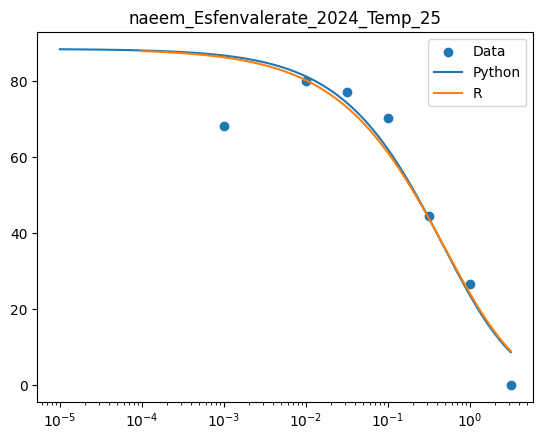

naeem_Esfenvalerate_2024_Food_1% + Temp_25


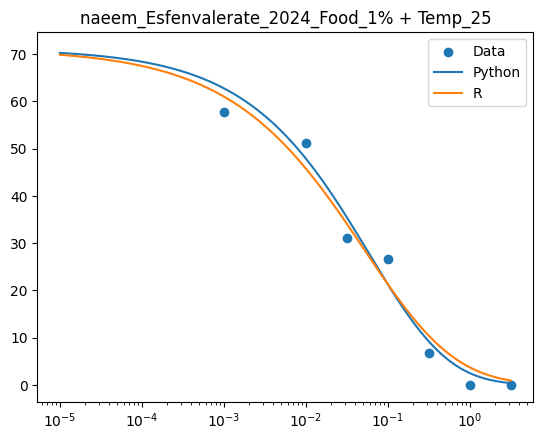

bps_esf_food_2024_Food_1%


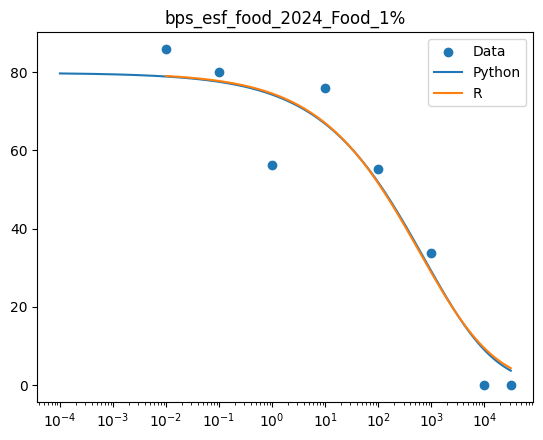

bps_esf_food_2024_Esfenvalerate_0.01


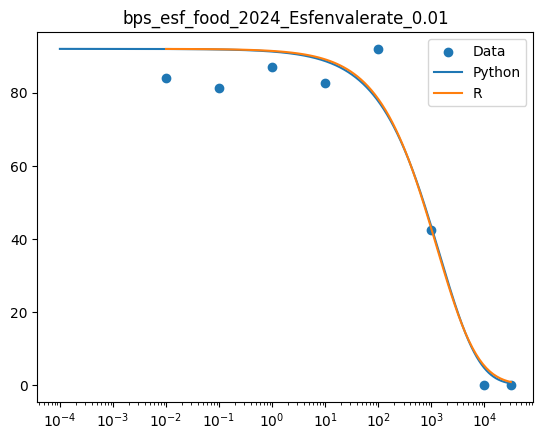

bps_esf_food_2024_Esfenvalerate + Food_1%


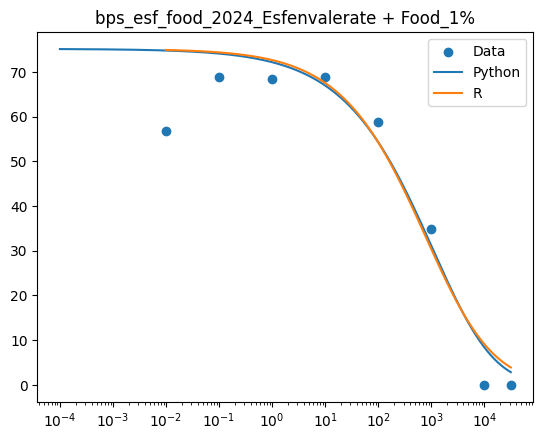

ayesha-cloth_Clothianidin_2024_reference_pre-contamination_Temp_20


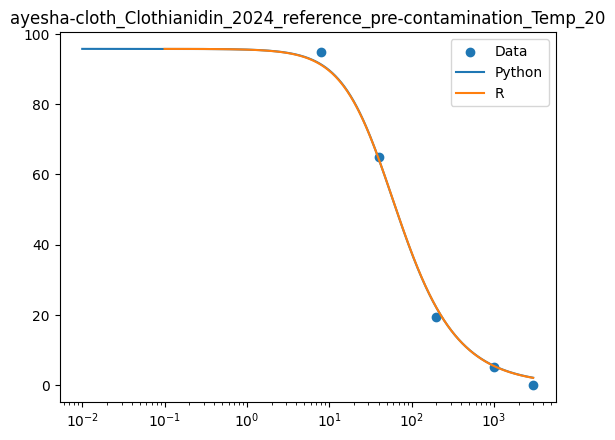

ayesha-cloth_Clothianidin_2024_reference_pre-contamination_Temp_24


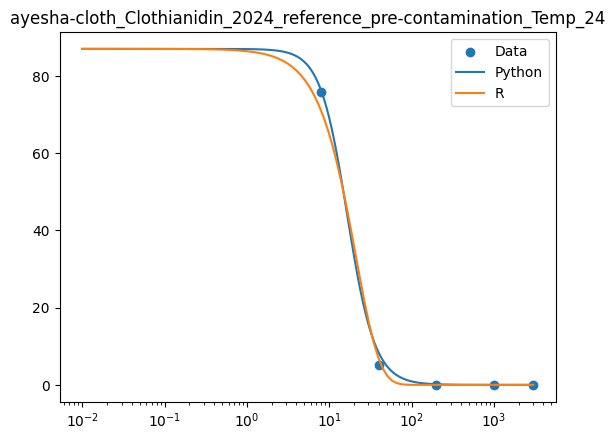

ayesha-cloth_Clothianidin_2024_reference_Temp_20


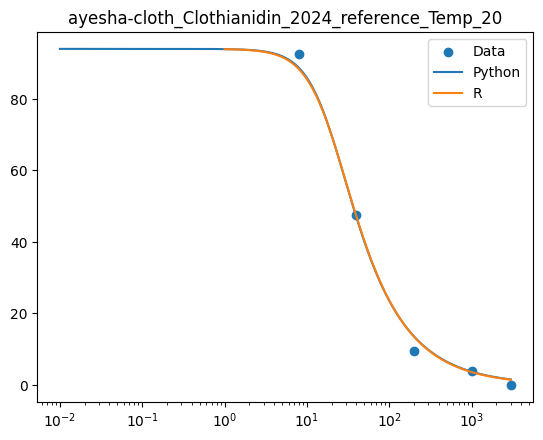

ayesha-cloth_Clothianidin_2024_reference_Temp_24


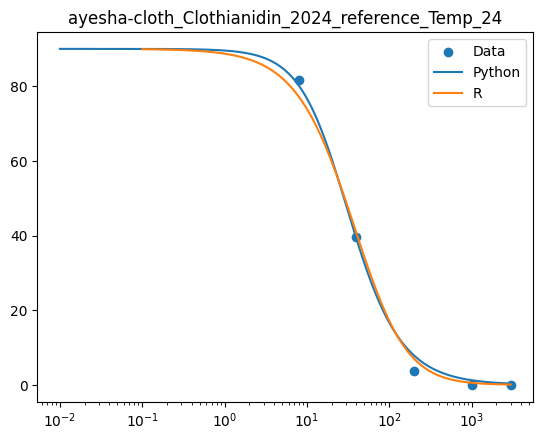

naeem_Mix13_2024_Food_1%


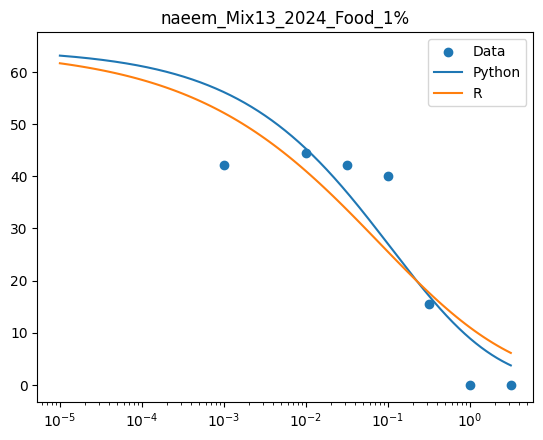

naeem_Mix13_2024_Temp_25


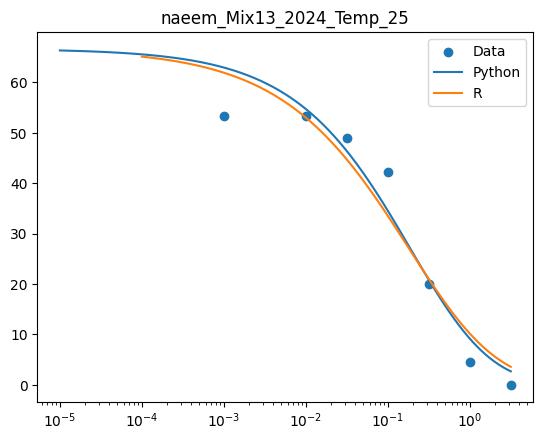

naeem_Mix13_2024_Temp_25 + Food_1%


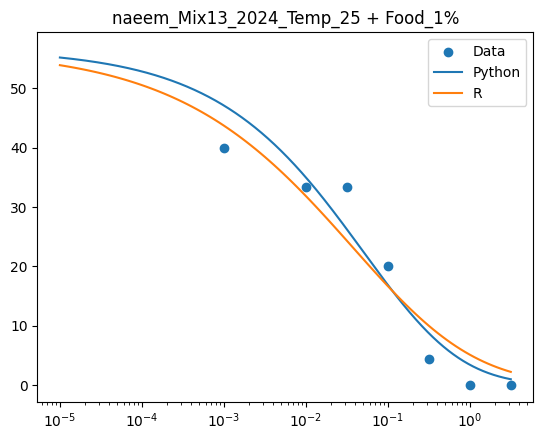

naemm_Clothianidin_2024_agricultural_Prochloraz_1


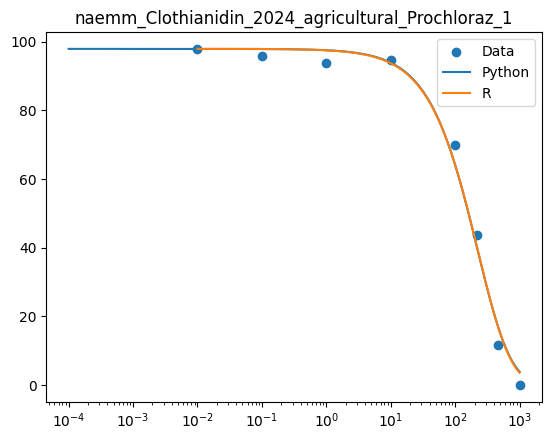

naemm_Clothianidin_2024_agricultural_Prochloraz_10


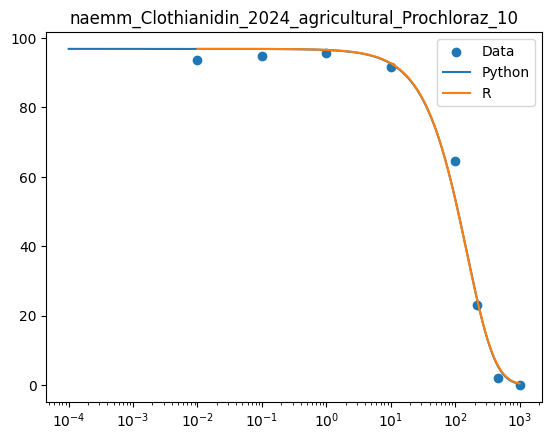

naemm_Clothianidin_2024_agricultural_Temp_19


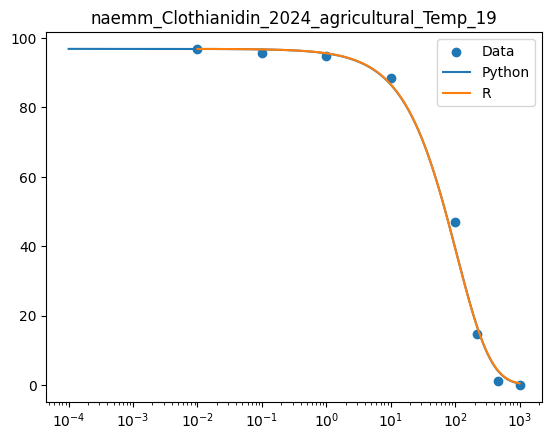

naemm_Clothianidin_2024_agricultural_Temp_19 + Prochloraz_1


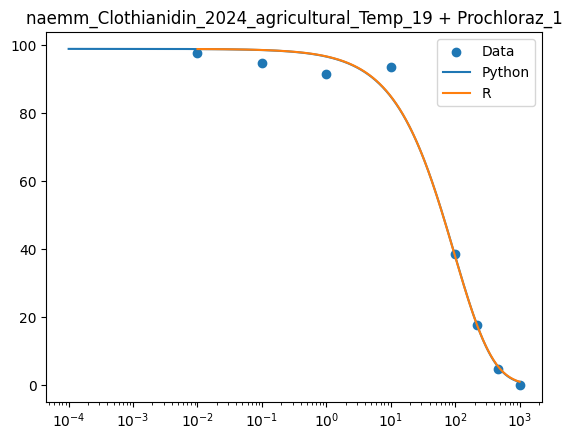

naemm_Clothianidin_2024_agricultural_Temp_19 + Prochloraz_10


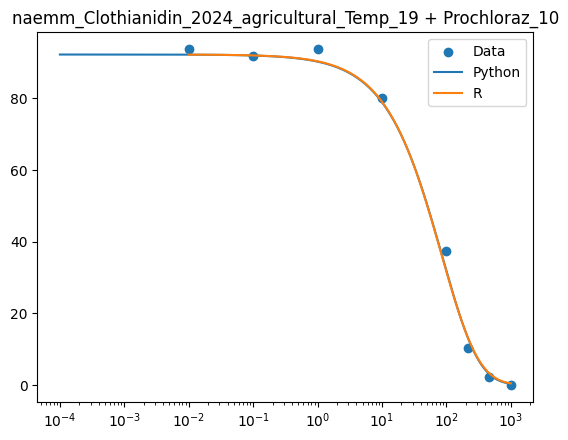

naemm_Clothianidin_2024_agricultural_Temp_22


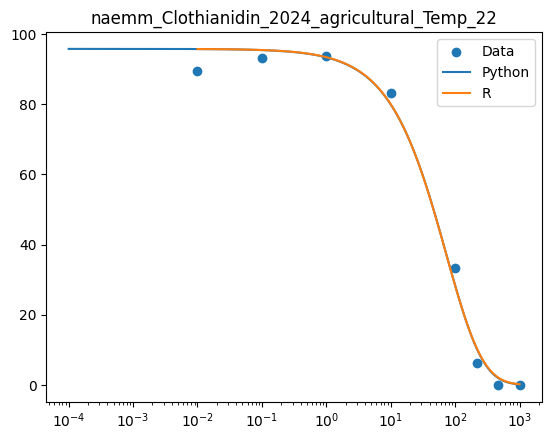

naemm_Clothianidin_2024_agricultural_Temp_22 + Prochloraz_1


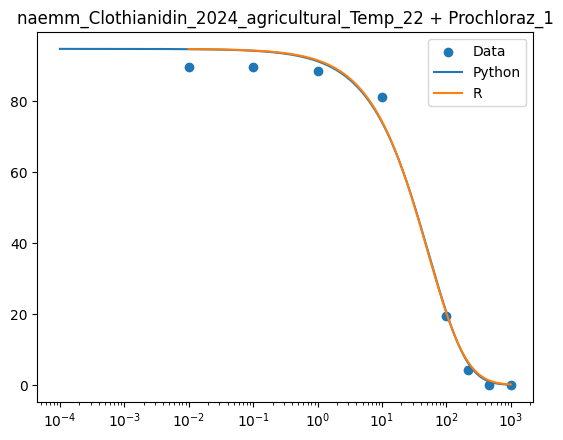

naemm_Clothianidin_2024_agricultural_Temp_22 + Prochloraz_10


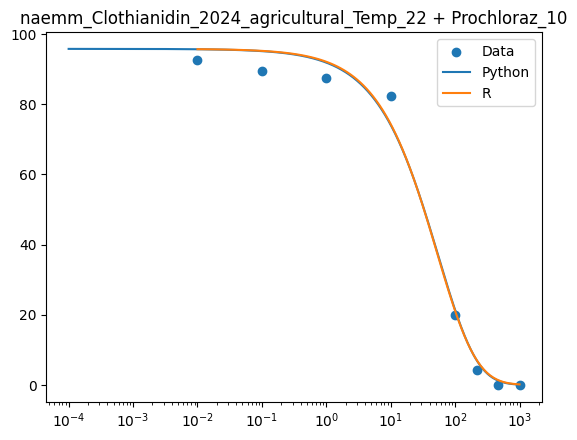

liess_copper_2001_Food_1%


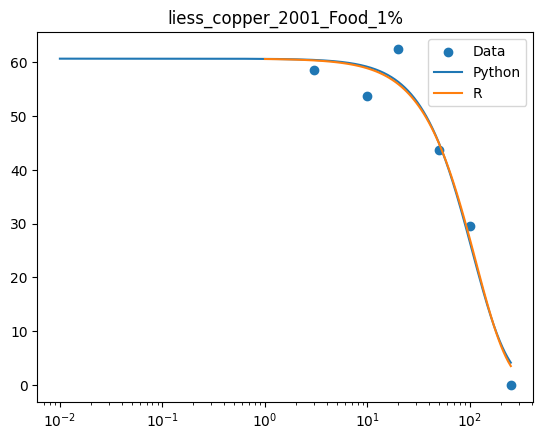

liess_copper_2001_UV


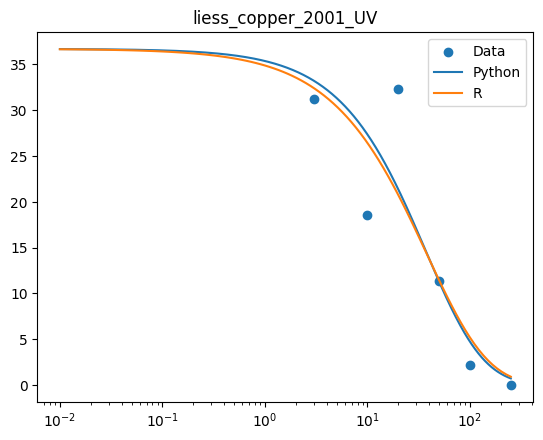

liess_copper_2001_Food_1% + UV


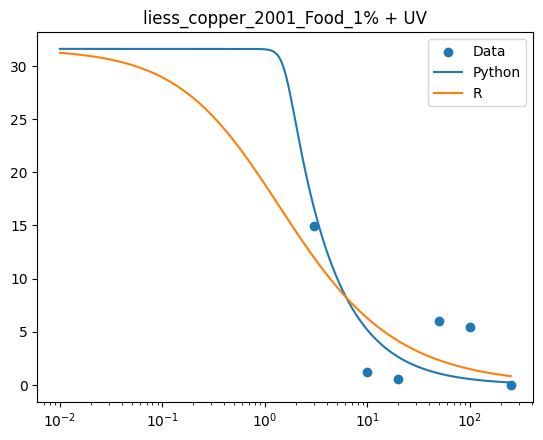

liess_copper_2001_Food_Avg


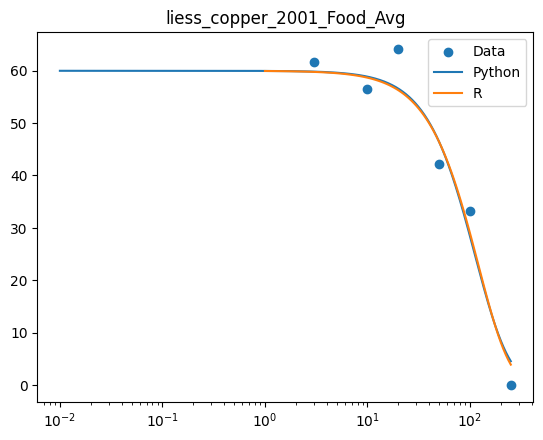

ayesha-cloth_Clothianidin_2024_agricultural_Temp_20


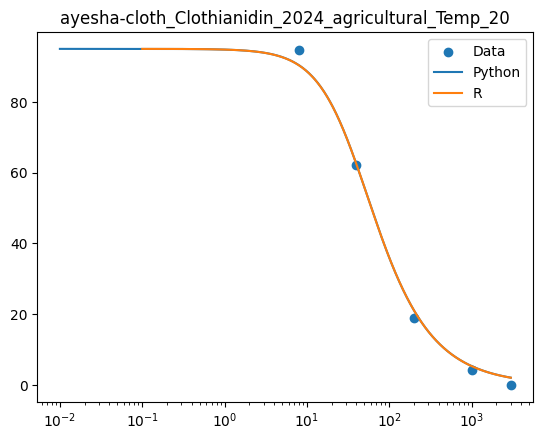

ayesha-cloth_Clothianidin_2024_agricultural_Temp_24


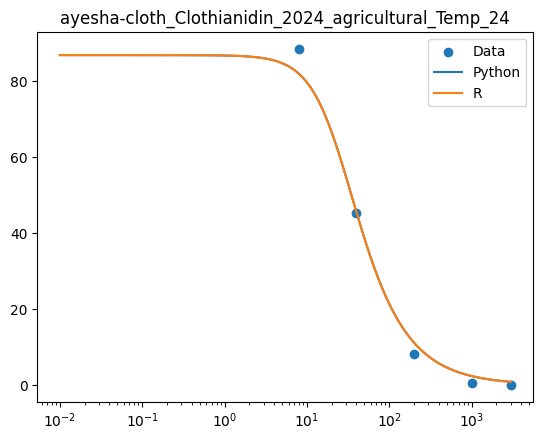

naemm_Clothianidin_2024_reference_Prochloraz_1


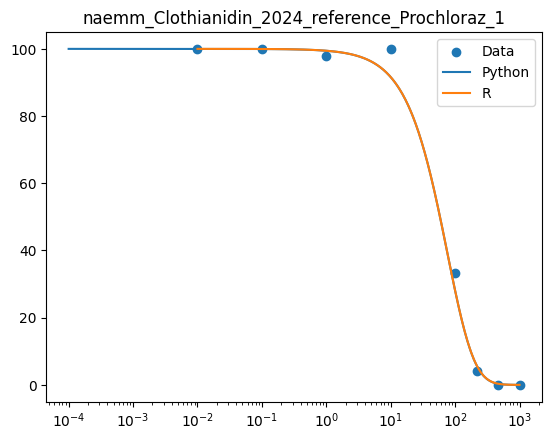

naemm_Clothianidin_2024_reference_Prochloraz_10


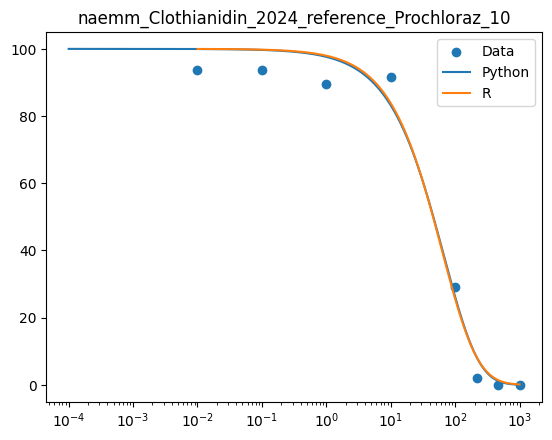

naemm_Clothianidin_2024_reference_Temp_19


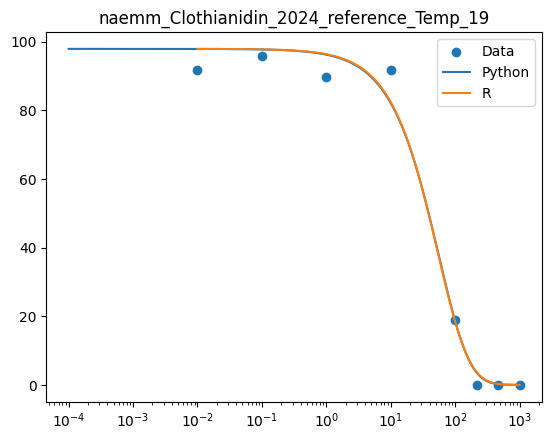

naemm_Clothianidin_2024_reference_Temp_19 + Prochloraz_1


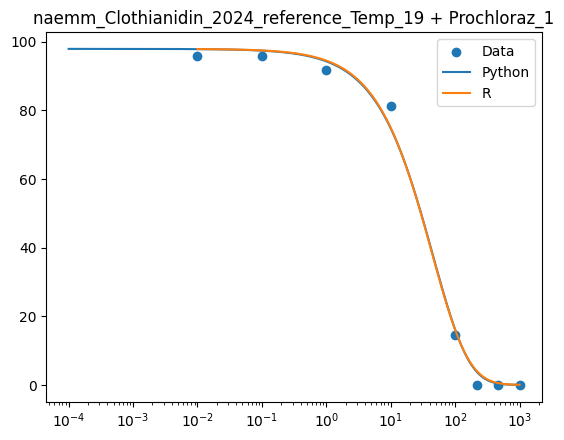

naemm_Clothianidin_2024_reference_Temp_19 + Prochloraz_10


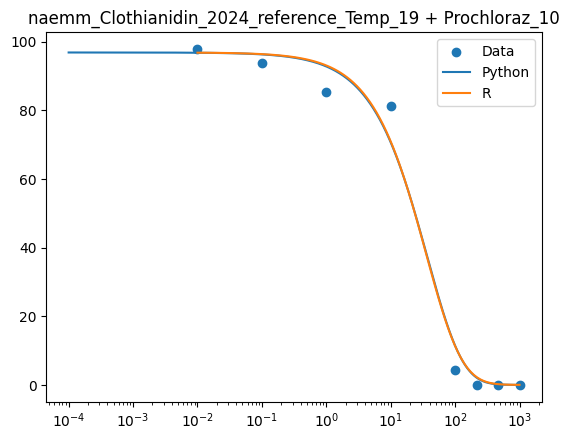

naemm_Clothianidin_2024_reference_Temp_22


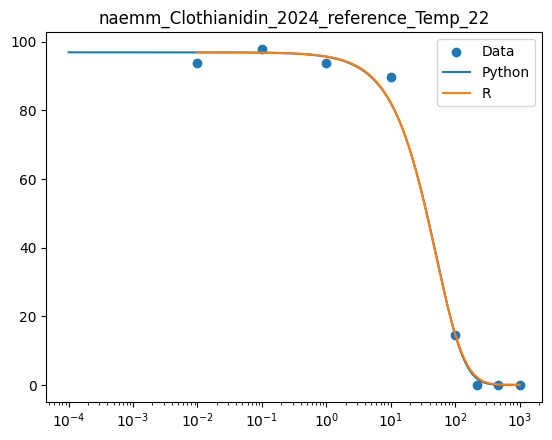

naemm_Clothianidin_2024_reference_Temp_22 + Prochloraz_1


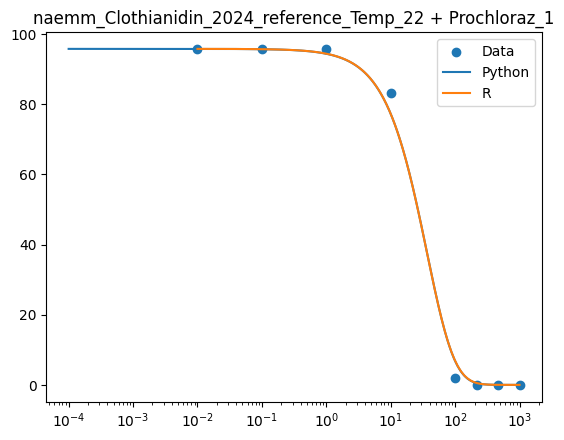

naemm_Clothianidin_2024_reference_Temp_22 + Prochloraz_10


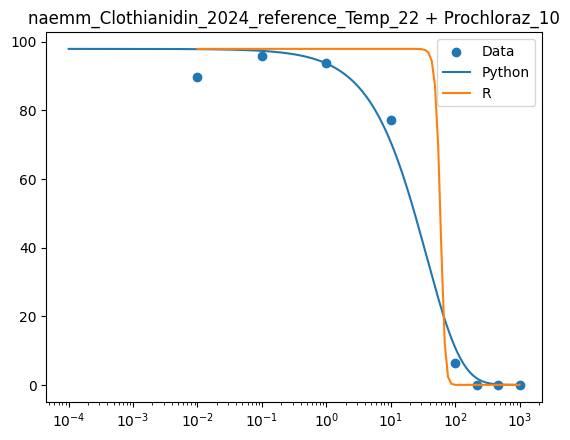

huang_imidachloprid_2023_Temp_15


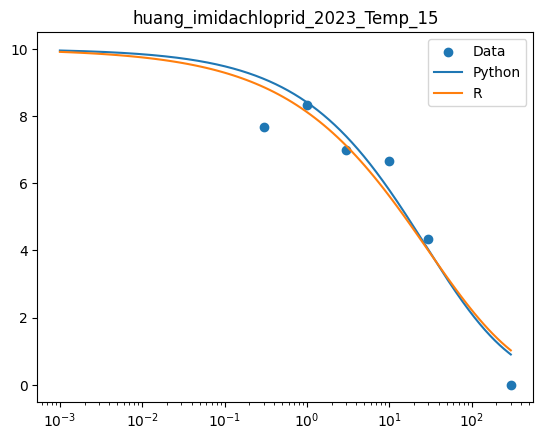

imrana_salt_2024_Food_1%


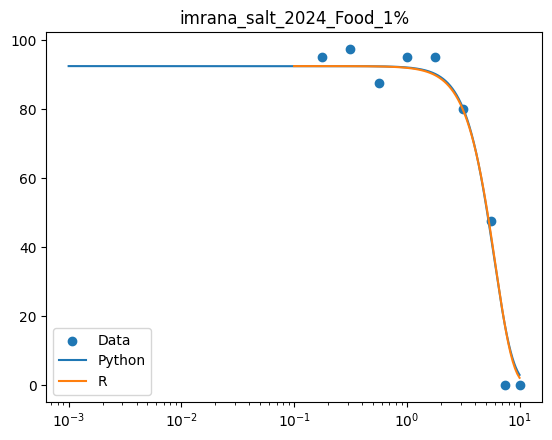

In [49]:
for r_pred, stress_fit, title in preds:
    stress_fit : ModelPredictions
    plt.scatter(stress_fit.inputs.concentration, stress_fit.inputs.survival_rate, label = "Data")
    
    plt.plot(stress_fit.concentration_curve, stress_fit.survival_curve, label = "Python")
    
    plt.plot(r_pred.Concentration, r_pred.Survival_B, label = "R")
    plt.legend()
    plt.xscale("log")
    plt.title(title)
    print(title)
    plt.show()
    

True True


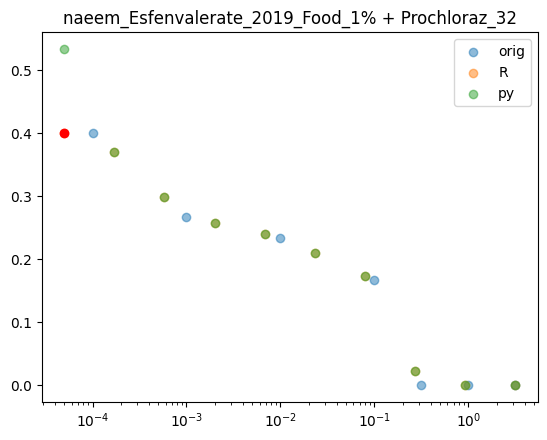

True True


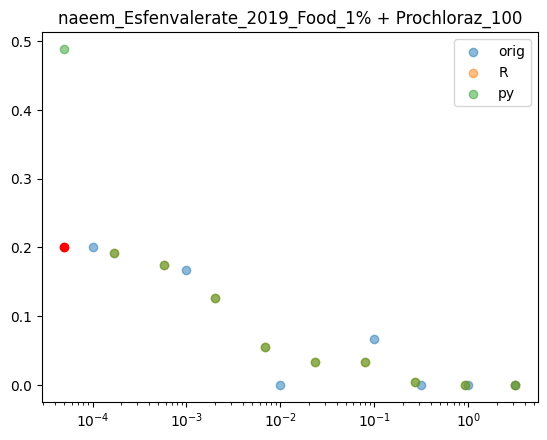

True True


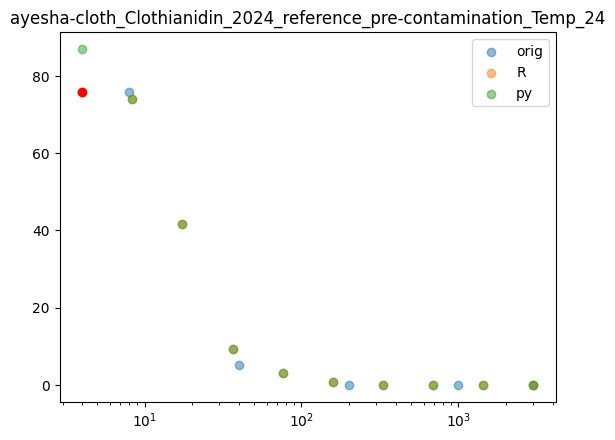

True True


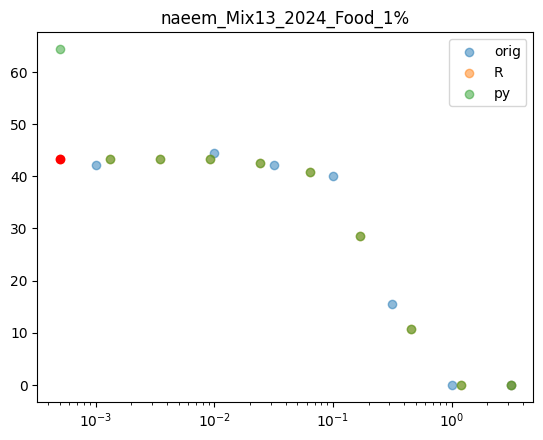

True True


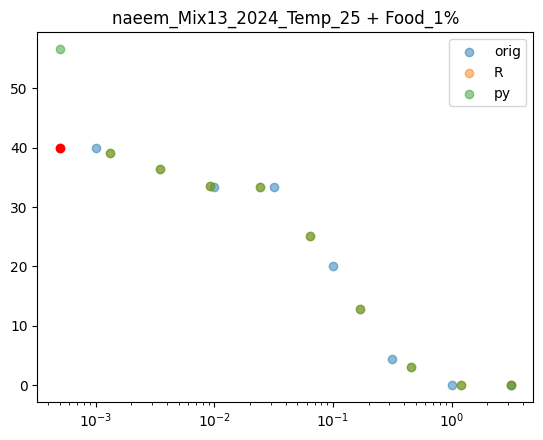

True False


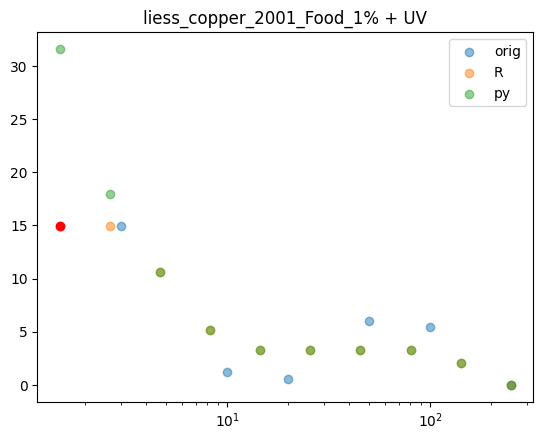

True True


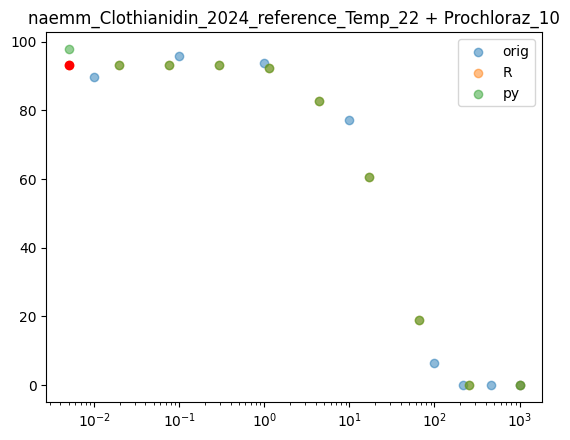

In [56]:
interesting = """naeem_Esfenvalerate_2019_Food_1% + Prochloraz_32
naeem_Esfenvalerate_2019_Food_1% + Prochloraz_100
ayesha-cloth_Clothianidin_2024_reference_pre-contamination_Temp_24
naeem_Mix13_2024_Food_1%
naeem_Mix13_2024_Temp_25 + Food_1%
liess_copper_2001_Food_1% + UV
naemm_Clothianidin_2024_reference_Temp_22 + Prochloraz_10
"""

for r_pred, stress_fit, title in preds:
    
    if title not in interesting.splitlines():
        continue
    
    stress_fit : ModelPredictions
    
    stress_sur = stress_fit.regress_surv * stress_fit.cfg.survival_max
    r_conc = r_pred.b_conc_t.dropna()
    r_surv = r_pred.b_surv_t.dropna()
    plt.scatter(stress_fit.inputs.concentration, stress_fit.inputs.survival_rate, label = "orig", alpha=0.5)
    plt.scatter(r_conc, r_surv, label = "R", alpha=0.5)
    plt.scatter(stress_fit.regress_conc, stress_sur, label = "py", alpha=0.5)
    plt.scatter(r_conc[1], r_surv[1], color = "red")
    plt.legend()
    plt.xscale("log")
    
    # conc_close = np.allclose(stress_fit.regress_conc , r_conc[1:])
    
    # sur_same = np.isclose(stress_sur, r_surv[1:])
    plt.title(title)
    # sur_close = ~sur_same[0] and np.all(sur_same[1:])
    # print(conc_close, sur_close)
    plt.show()
    


In [ ]:
r_pred = pd.read_csv("migration/r/naeem_Mix13_2024_Temp_25 + Food_1%_williams_and_linear_interpolation_lmcurve.csv")
r_pred.head()

,Concentration,Survival_A,Survival_B,SAM,EA,CA,LC_SAM_Concentration,LC_SAM_Survival,a_conc_t,a_surv_t,b_conc_t,b_surv_t
0,0.000010,82.219594,53.916476,55.200947,56.664720,56.663941,0.000422,50.9985,0.000000,82.220000,0.000000,56.665000
1,0.000011,82.219531,53.789546,55.132540,56.664677,56.663797,0.029891,28.3325,0.000500,74.811111,0.000500,39.996667
2,0.000013,82.219458,53.656961,55.060890,56.664627,56.663632,NaN,NaN,0.001322,74.811111,0.001322,39.188187
3,0.000015,82.219374,53.518488,54.985841,56.664569,56.663446,NaN,NaN,0.003496,74.811111,0.003496,36.372841
4,0.000017,82.219278,53.373888,54.907227,56.664502,56.663234,NaN,NaN,0.009244,74.811111,0.009244,33.557495


In [3]:
data = read_data("data/naeem_Mix13_2024.xlsx")
exp = data.additional_stress["Temp_25 + Food_1%"]

main_fit, stress_fit, sam_sur, sam_stress, additional_stress  = sam_prediction(data.main_series, exp, data.meta, OLD_STANDARD)

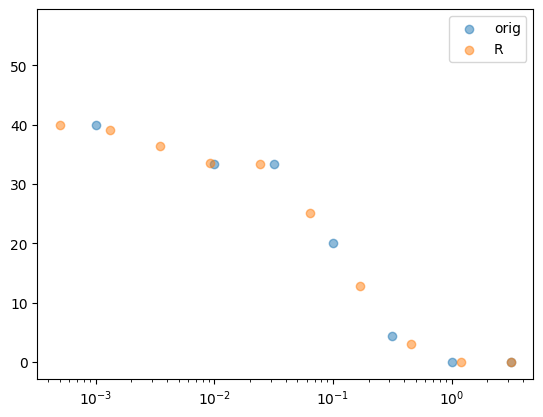

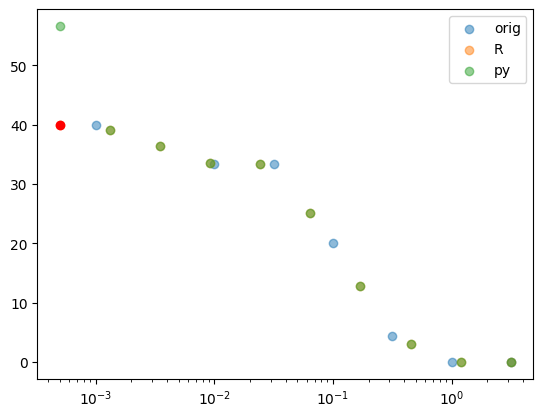

In [41]:
r_conc = r_pred.b_conc_t.dropna()
r_surv = r_pred.b_surv_t.dropna()
plt.scatter(exp.concentration, exp.survival_rate, label = "orig", alpha=0.5)
plt.scatter(r_conc, r_surv, label = "R", alpha=0.5)
# plt.scatter(stress_fit.regress_conc, stress_fit.regress_surv * 100, label = "py", alpha=0.5)
plt.legend()
plt.xscale("log")
plt.show()

r_conc = r_pred.b_conc_t.dropna()
r_surv = r_pred.b_surv_t.dropna()
plt.scatter(exp.concentration, exp.survival_rate, label = "orig", alpha=0.5)
plt.scatter(r_conc, r_surv, label = "R", alpha=0.5)
plt.scatter(stress_fit.regress_conc, stress_fit.regress_surv * 100, label = "py", alpha=0.5)
plt.scatter(r_conc[1], r_surv[1], color = "red")
plt.legend()
plt.xscale("log")
plt.show()

In [37]:
stress_fit.regress_surv[:4]

array([0.56665   , 0.39188187, 0.36372841, 0.33557495])

In [38]:
r_surv[:5]

0    56.665000
1    39.996667
2    39.188187
3    36.372841
4    33.557495
Name: b_surv_t, dtype: float64

In [21]:
stress_fit.regress_conc

array([5.00000000e-04, 1.32212313e-03, 3.49601912e-03, 9.24433547e-03,
       2.44442994e-02, 6.46367471e-02, 1.70915476e-01, 4.51942608e-01,
       1.19504755e+00, 3.16000000e+00])

In [30]:
np.isclose(stress_fit.regress_conc , r_conc[1:])

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

In [32]:
np.isclose(stress_fit.regress_surv * 100 , r_surv[1:])

array([False,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

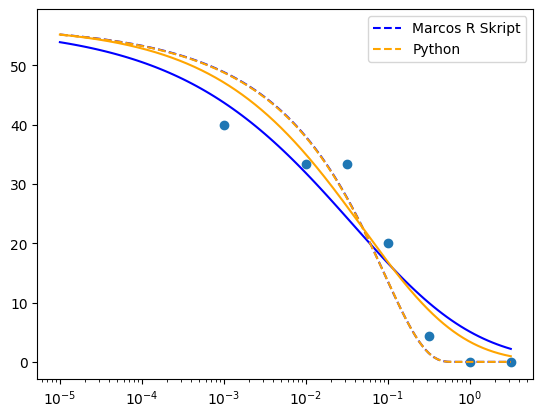

In [20]:
plt.plot(r_pred.Concentration,r_pred.SAM, label = "Marcos R Skript", color ="blue", linestyle = "--")
plt.plot(r_pred.Concentration,r_pred.Survival_B, color ="blue")

plt.plot(main_fit.concentration_curve, sam_sur, label = "Python", color = "orange", linestyle = "--")
plt.plot(main_fit.concentration_curve, stress_fit.survival_curve,  color = "orange")
plt.scatter(exp.concentration, exp.survival_rate)
plt.legend()
plt.xscale("log")
plt.show()